# Predicting Functionality of Water Pumps in Tanzania

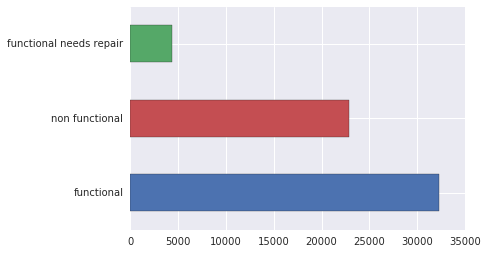

In [413]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


df_orig=pd.read_csv('Training_set_values.csv',parse_dates=True)
df_labels=pd.read_csv('Training_set_labels.csv')
df_topredict=pd.read_csv('Test_set_values.csv',parse_dates=True)
df_orig.head()
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
df_labels.status_group.value_counts().plot(kind='barh', colors=palette)

## Look at data

There are 40 features mostly categorical (+latitude, longitude, gps height). We have 3 labels for the status of the pump: 'functional','functional needs repair','non functional'

Showing below relationship between some categories and labels

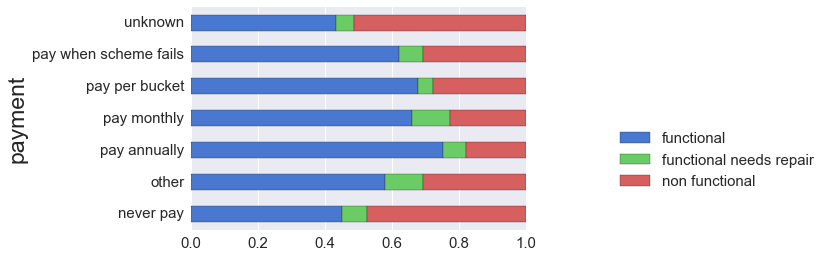

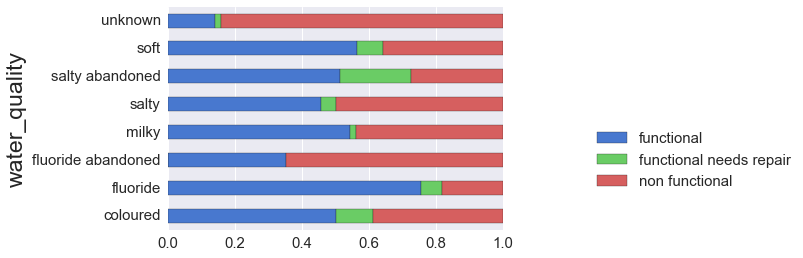

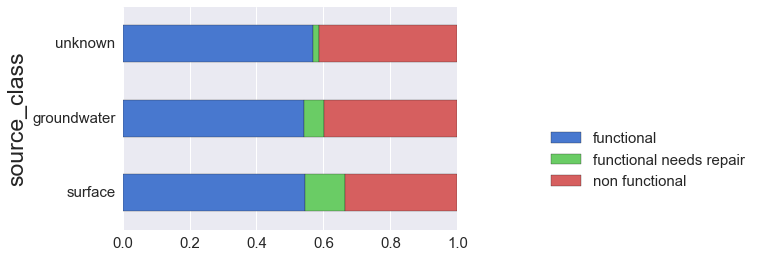

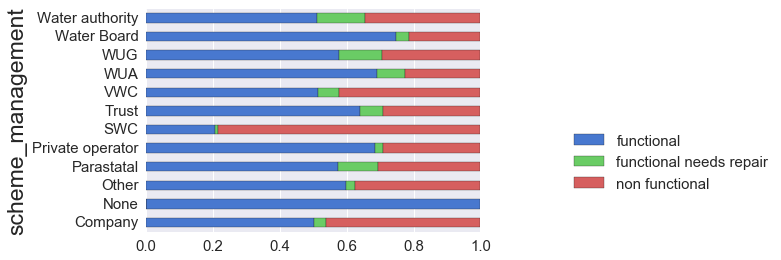

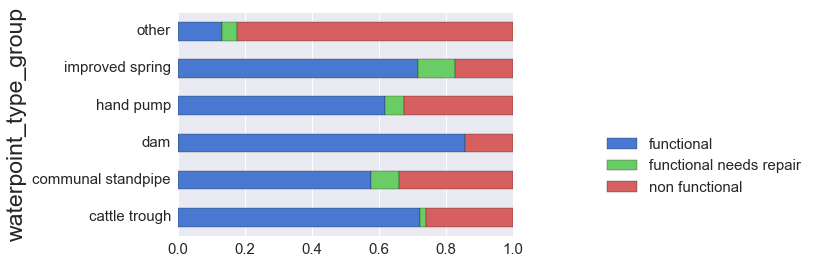

In [334]:
import seaborn as sns

factorstoplot=['payment','water_quality','source_class','scheme_management','waterpoint_type_group']
for i in range(1,len(factorstoplot)+1):
    df_orig['status'] = pd.Series(df_labels.status_group)
    thisFactor=factorstoplot[i-1]
    sumfactor=df_orig.groupby([thisFactor]).status.count()
    temp=pd.DataFrame(df_orig.groupby([thisFactor]).status.value_counts()/sumfactor)
    temp['status']=temp.index.get_level_values('status')
    temp['source']=temp.index.get_level_values(thisFactor)
    temp.columns=['n','status',thisFactor]
    temp=temp.pivot(index=thisFactor, columns='status', values='n')
    temp['tot']=temp.sum(axis=1)
    temp.sort_values(by='tot', ascending=True)[['functional','functional needs repair','non functional']].plot(kind='barh', stacked='True', fontsize=15,legend=False)
    plt.legend( loc='upper right', bbox_to_anchor=(1.9, 0.5),fontsize=15)
    plt.ylabel(thisFactor, fontsize=23)


## Preprocessing

* All missing values of latitude, longitude and height (listed as 0s) are converted to the mean value within their administrative region
* For categorical variables, values that are rare (less than 20 occurences) are converted into "Others"
* Categorical variables are converted into numbers
* A new variable is introduced: timeago (how long ago the pump was checked) 
* Test: these preprocessing steps increase the score of a Random Forest by 5%

In [335]:
df=df_orig.append(df_topredict)


factorschange=[x for x in df.columns if x not in ['id','latitude','longitude','gps_height','date_recorded']]

for factor in factorschange:


    values_factor=df_orig[factor].value_counts()
    lessthen=values_factor[values_factor < 20]
    listnow=df_orig.installer.isin(list(lessthen.keys()))
    df_orig.loc[listnow,factor] = 'Others'

    # names to numbers
    df[factor] = preprocessing.LabelEncoder().fit_transform(df[factor])

df.population = df.population.apply(lambda x: np.log10(x+1))
df['timeago']=-(pd.to_datetime(df.date_recorded) - pd.to_datetime('2015-01-01'))
df['timeago']=df.timeago.apply(lambda x: int(x)/100000000000.)
  
a= df[df["longitude"] < 1]
a.iloc[:,df.columns == "latitude"]= np.nan
a.iloc[:,df.columns == "longitude"]= np.nan
df[df["longitude"] < 1] = a
df["longitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
df["latitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude

a= df[df["gps_height"] < 1]
a.iloc[:,df.columns == "gps_height"]= np.nan
df[df["gps_height"] < 1] = a
df["gps_height"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

df=df.fillna(df.mean())



df_topredict = df[len(df_orig):]
df = df[:len(df_orig)]





## Split datasets

Create testing and training samples

In [354]:
# use these variables - room for improvement here
factors=['amount_tsh', u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group','timeago']
# factors = ["funder","installer","management",
#                "region","lga","population",
#                "latitude","longitude","gps_height",
#                "scheme_management",
#                "public_meeting","permit",
#                "water_quality","quantity",
#                "payment_type","source","source_class",
#                "management","management_group",
#                "basin","extraction_type","waterpoint_type",
#                "timeago"]

X_train, X_test, y_train, y_test = train_test_split(df[factors], df_labels.status_group, test_size=0.05, random_state=10)




## Train and Score models

* Train a Decision Tree, and a Random Forest
* Score on Test data
* Random Forest recovers ~80% of the variance in the status of the pumps.

Random Forest 0.814478114478
Decision Tree 0.672390572391
Extra Trees Classifiers 0.806734006734


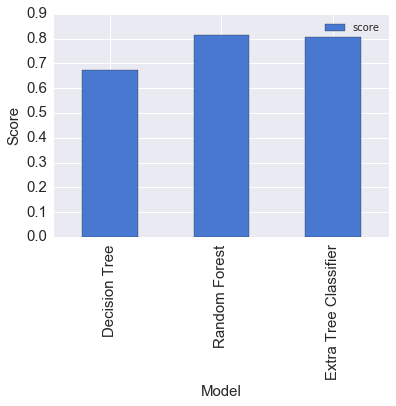

In [355]:
modelRFC = RandomForestClassifier(n_estimators=500,min_samples_split=10,criterion='gini')

X_test=(X_test - X_test.min())/(X_test.max() - X_test.min())
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

modelRFC.fit(X_train, y_train)

modelETC = ExtraTreesClassifier(n_estimators=500,min_samples_split=20)
modelETC.fit(X_train, y_train)


modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

scoreRFC= modelRFC.score(X_test,y_test)
scoreDTC= modelDTC.score(X_test,y_test)
scoreETC= modelETC.score(X_test,y_test)



print 'Random Forest' ,scoreRFC
print 'Decision Tree', scoreDTC
print 'Extra Trees Classifiers', scoreETC


pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

## Fit model

* Train model on entire test dataset
* Predict missing labels and export them

In [328]:
modelRFC = RandomForestClassifier(n_estimators=500,min_samples_split=10,criterion='gini')
# modelETC = ExtraTreesClassifier(n_estimators=500,min_samples_split=20)


X_train=df[factors]
y_train =df_labels.status_group
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

modelRFC.fit(X_train, y_train)
# modelETC.fit(X_train, y_train)



X_topredict=df_topredict[factors]
X_topredict=(X_topredict - X_topredict.min())/(X_topredict.max() - X_topredict.min())
predict=modelRFC.predict(X_topredict)
# predict=modelETC.predict(X_topredict)


df_topredict['status_group']=predict

df_topredict[['id','status_group']].to_csv('outputRFC.csv',index=False)

## Confusion Matrix

Showing relation between predicted categories and real categories on the test data.

We are doing fairly well on 'functional' and 'non functional'. 

'Functional needs repair' is the hardest to predict. Most of the real ones end up in 'functional'.

Confusion matrix, without normalization
[[1538   19  103]
 [ 121   52   26]
 [ 271   11  829]]
Normalized confusion matrix
[[ 0.93  0.01  0.06]
 [ 0.61  0.26  0.13]
 [ 0.24  0.01  0.75]]


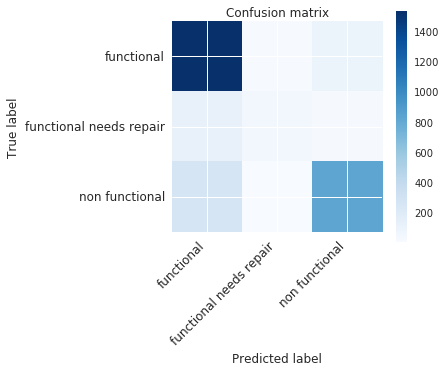

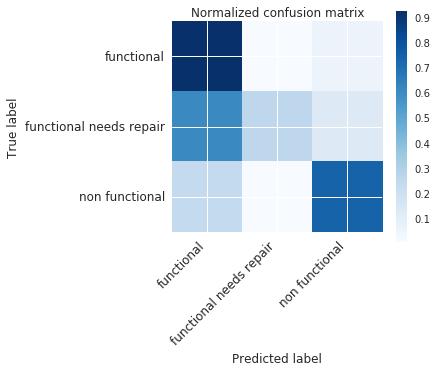

Test Score 0.814478114478


In [439]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, modelRFC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print 'Test Score', cm.diagonal().sum()/float(cm.sum())